In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import special


import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:


#input_dir = 'hist-pdf-toy-study-1d-1a-perfect'
#input_dir = 'hist-pdf-toy-study-1d-1a-goodres'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1b-mediumbad'


#input_dir = 'bootstrap-toy-study8a-1d-1d-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-1d-goodres'
#input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'
#input_dir = 'bootstrap-toy-study8a-1d-1d-mediumbad'






#input_dir = 'bootstrap-toy-study8a-1d-2a-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-2a-nominal-resolution'


#input_dir = 'bootstrap-toy-study8a-1d-2a'


#input_dir = 'hist-pdf-toy-study-1d-2a-discretized-data-perfect'
#input_dir = 'hist-pdf-toy-study-1d-2a-discretized-data-goodres'
#input_dir = 'hist-pdf-toy-study-1d-2a-discretized-data-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-2a-discretized-data-mediumbad'



input_dir = 'hist-pdf-toy-study-1d-3b'




#fitType = 'bin center approximation'
fitType = 'integral within bin'





rcond_val = 0.001

diagonal_constant = 1.0






hist_nbins = 20
hist_xlow = -3.
hist_xhigh = 3.



#hist_nbins = 60
#hist_xlow = -9.
#hist_xhigh = 9.



#generate_test_data = True
generate_test_data = False




with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (100000, 1)
 shape of true_pts:   (9930, 1)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)
ngen_true = int(cu.get_par( config_file, "ngen_true"))
print(' ngen_true = %d\n' % ngen_true )



 Number of feature dimensions: 1


 ngen_true = 10000



In [5]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

In [6]:
true_cov = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        k = ndim - j - 1
        if i == j :
            true_cov[i][j] = true_sig[i]*true_sig[i]
        elif j > i :
            print(" %d, %d, %d" % (i,j,k))
            true_cov[i][j] = true_rho[i][k] * true_sig[i] * true_sig[j]

In [7]:


with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)

main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

print('\n\n')
print(' shape of main_sample_omnifold_weights: %s' % str(main_sample_omnifold_weights.shape))
print('\n\n')





 shape of main_sample_omnifold_weights: (100000,)





In [8]:
main_sample_omnifold_weights

array([0.12016921, 0.09273315, 0.09743046, ..., 0.12416163, 0.04436094,
       0.09179701])

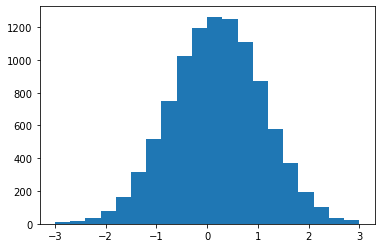

In [9]:
unfolded_hist,hist_bin_edges,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )

In [10]:
hist_bin_edges

array([-3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ,
        0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ])

In [11]:
hist_bin_centers = np.zeros( hist_nbins )
for bi in range(hist_nbins) :
    hist_bin_centers[bi] = 0.5*(hist_bin_edges[bi] + hist_bin_edges[bi+1])

In [12]:
hist_bin_centers

array([-2.85, -2.55, -2.25, -1.95, -1.65, -1.35, -1.05, -0.75, -0.45,
       -0.15,  0.15,  0.45,  0.75,  1.05,  1.35,  1.65,  1.95,  2.25,
        2.55,  2.85])

In [13]:
bin_width = hist_bin_edges[1] - hist_bin_edges[0]

In [14]:
weight_sum = np.sum( main_sample_omnifold_weights )
print('\n\n Sum of ominfold weights:  %.3f' % weight_sum )



 Sum of ominfold weights:  9913.401


In [15]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [16]:
mean_cov = calc_mean_cov( main_sample_omnifold_weights, 0, 0 )

In [17]:
mean_cov

{'mean_x1': 0.19464053950123275,
 'mean_x2': 0.19464053950123275,
 'cov_x1x2': 0.8258082941560422,
 'rms1': 0.908739948585976}

In [18]:
dummy_weights = np.ones( len(train_pts))
dummy_weights = (len(true_pts) / len(train_pts)) * dummy_weights

In [19]:
dummy_weights

array([0.0993, 0.0993, 0.0993, ..., 0.0993, 0.0993, 0.0993])

In [20]:
dummy_weights.shape

(100000,)

<function matplotlib.pyplot.show(close=None, block=None)>

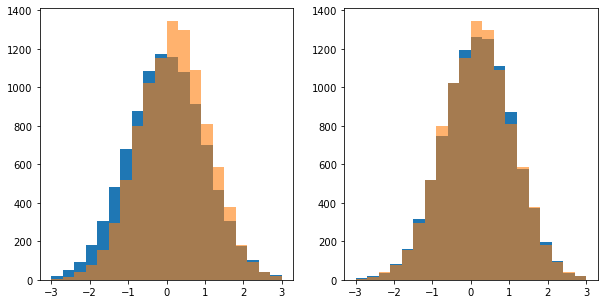

In [21]:
fig,ax = plt.subplots( 1, 2, figsize=(2*5,5))

ax[0].hist( train_pts[:,0], bins=hist_nbins, weights=dummy_weights, range=[hist_xlow, hist_xhigh] )
ax[0].hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh], alpha=0.6 )

ax[1].hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )
ax[1].hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh], alpha=0.6 )

plt.show

In [22]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 500 bootstrap samples.




 boot   0 weights: [0.11684558 0.09658155 0.11443714 ... 0.12097029 0.03746462 0.09514089]
 boot   1 weights: [0.12422788 0.0909384  0.10769243 ... 0.12415964 0.04264254 0.08905406]
 boot   2 weights: [0.12122247 0.09028419 0.11642109 ... 0.12513691 0.04721914 0.0888504 ]
 boot   3 weights: [0.12171171 0.09339071 0.10546028 ... 0.12208379 0.04219189 0.09210953]
 boot   4 weights: [0.12454804 0.09415191 0.0985614  ... 0.12864429 0.04660361 0.0928642 ]
 boot   5 weights: [0.12274087 0.09066686 0.10220806 ... 0.12535921 0.04510051 0.08922715]
 boot   6 weights: [0.12057102 0.09085567 0.10752164 ... 0.118551   0.0480175  0.08904652]
 boot   7 weights: [0.11853877 0.09333295 0.11481203 ... 0.12206986 0.0391189  0.09201557]
 boot   8 weights: [0.12179353 0.09297762 0.09390845 ... 0.1225026  0.04666175 0.09139597]
 boot   9 weights: [0.11907618 0.09748089 0.12183523 ... 0.12196146 0.05075671 0.0961238 ]
 boot  10 weights: [0.1193239  0.09364226 0.10853875 ... 0.1245951  0.04584631 0.09264521]

 boot 100 weights: [0.11896764 0.09628253 0.11376102 ... 0.12227818 0.04314076 0.09482618]
 boot 101 weights: [0.12078361 0.09364434 0.11353986 ... 0.12338036 0.04069201 0.09257426]
 boot 102 weights: [0.12044236 0.09244222 0.10714302 ... 0.12599681 0.04599461 0.0909455 ]
 boot 103 weights: [0.11721021 0.09123471 0.1043762  ... 0.12146015 0.04929864 0.08999269]
 boot 104 weights: [0.11765738 0.09159417 0.10981826 ... 0.12079368 0.04299587 0.09020508]
 boot 105 weights: [0.11863099 0.09677961 0.10876915 ... 0.12005181 0.04371742 0.09541984]
 boot 106 weights: [0.12471595 0.09149924 0.10719675 ... 0.12662413 0.04464028 0.08994801]
 boot 107 weights: [0.12210409 0.09549513 0.10237288 ... 0.12730027 0.04142463 0.09429059]
 boot 108 weights: [0.11865246 0.09196839 0.12101329 ... 0.12107951 0.04409188 0.09055521]
 boot 109 weights: [0.1198365  0.09432105 0.11859777 ... 0.12329461 0.04040487 0.09301268]
 boot 110 weights: [0.12443728 0.0912707  0.09422035 ... 0.12741202 0.04947911 0.08975426]

 boot 202 weights: [0.12181674 0.09173808 0.1032783  ... 0.12437483 0.04419466 0.09006501]
 boot 203 weights: [0.11991875 0.09270955 0.1040439  ... 0.11958801 0.04934171 0.09110502]
 boot 204 weights: [0.12122483 0.09342168 0.09388044 ... 0.11959384 0.0466774  0.09164456]
 boot 205 weights: [0.11946628 0.09236396 0.11055559 ... 0.12105361 0.04921966 0.09101188]
 boot 206 weights: [0.11851441 0.0934191  0.11164204 ... 0.11841626 0.04152929 0.09214305]
 boot 207 weights: [0.11957758 0.09483958 0.1173317  ... 0.1196998  0.05025567 0.09306075]
 boot 208 weights: [0.12128821 0.09176022 0.11640759 ... 0.12635391 0.04349779 0.09039763]
 boot 209 weights: [0.11745372 0.0954415  0.11584955 ... 0.1216988  0.04940937 0.09452919]
 boot 210 weights: [0.12141348 0.09518449 0.10526263 ... 0.12332085 0.04037019 0.09364666]
 boot 211 weights: [0.11673886 0.09338133 0.10423985 ... 0.11735268 0.04423743 0.09219037]
 boot 212 weights: [0.12237278 0.09146697 0.11211412 ... 0.12300038 0.04232651 0.08983042]

 boot 302 weights: [0.11726291 0.09426605 0.10846368 ... 0.12384099 0.04288604 0.09327846]
 boot 303 weights: [0.12258895 0.09065846 0.09758642 ... 0.12501717 0.0402053  0.089253  ]
 boot 304 weights: [0.11670417 0.09247183 0.1101559  ... 0.12074007 0.05123189 0.09114251]
 boot 305 weights: [0.11956096 0.09437599 0.10322743 ... 0.12316361 0.04733777 0.09321843]
 boot 306 weights: [0.12334513 0.09009275 0.10768842 ... 0.12477716 0.0503306  0.08846782]
 boot 307 weights: [0.12188186 0.09087333 0.10304647 ... 0.12899261 0.04710183 0.08957603]
 boot 308 weights: [0.11736555 0.09201099 0.11592057 ... 0.12281423 0.04434221 0.09099024]
 boot 309 weights: [0.11792993 0.09036344 0.11083577 ... 0.12281924 0.04860781 0.08913931]
 boot 310 weights: [0.11490435 0.09231755 0.10812608 ... 0.11996986 0.04636843 0.09105374]
 boot 311 weights: [0.11930067 0.09334432 0.09631948 ... 0.12408918 0.04761042 0.0920995 ]
 boot 312 weights: [0.12603766 0.09149177 0.10415786 ... 0.12854627 0.04700198 0.09027299]

 boot 398 weights: [0.11791653 0.09495728 0.12111665 ... 0.12157829 0.05238249 0.09364811]
 boot 399 weights: [0.12490684 0.09001785 0.10680163 ... 0.12751515 0.04643876 0.08824717]
 boot 400 weights: [0.11943475 0.09089394 0.11430911 ... 0.12419156 0.04023575 0.08950367]
 boot 401 weights: [0.11992556 0.09260329 0.12859631 ... 0.12430958 0.04665202 0.09123252]
 boot 402 weights: [0.12177074 0.08831702 0.09838204 ... 0.12590092 0.04979005 0.08656109]
 boot 403 weights: [0.11639189 0.09290107 0.11889363 ... 0.11904283 0.04634621 0.09153261]
 boot 404 weights: [0.11792446 0.09191791 0.10198544 ... 0.11970692 0.04294104 0.09056335]
 boot 405 weights: [0.11883205 0.09371934 0.10729863 ... 0.12379144 0.04603003 0.09248803]
 boot 406 weights: [0.12075959 0.09243051 0.10653458 ... 0.12212957 0.04215242 0.09076543]
 boot 407 weights: [0.11793332 0.09540719 0.10952618 ... 0.11922876 0.04570313 0.09419859]
 boot 408 weights: [0.11851537 0.09342082 0.1133657  ... 0.12083953 0.04518764 0.09228848]

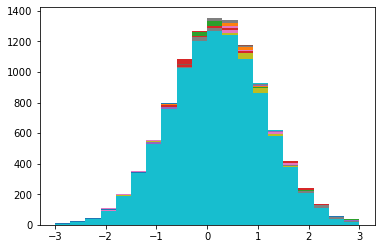

In [23]:
boot_hist_content = np.zeros( shape=(n_samples, hist_nbins))


simple_calc_mean = np.zeros( n_samples )
simple_calc_cov  = np.zeros( n_samples )

of_weight_sum = np.zeros( n_samples )


for bi in range(n_samples) :
    

        

            
    if generate_test_data :
            
        print(' Generating sample %3d' % bi )
            
        true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        hist_content,_,_ = plt.hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh] )
        boot_hist_content[bi,:] = hist_content
            
        x_mean = np.mean( true_pts[:,0] )
        x2_mean = np.mean( np.square( true_pts[:,0]) )
        x_cov = x2_mean - x_mean * x_mean
            
        simple_calc_mean[bi] = x_mean
        simple_calc_cov[bi] = x_cov
            
    else :
            
        fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)

        if not exists(fname) :  
            print('\n\n *** Missing %s' % fname )
            continue
            
        with open(fname,'rb') as f :            
            
            final_push_weights_scaled = np.load(f)
            print(' boot %3d weights: ' % bi, end='')
            print( final_push_weights_scaled)

            of_weight_sum[bi] = np.sum( final_push_weights_scaled )

            hist_content,_,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=final_push_weights_scaled, range=[hist_xlow, hist_xhigh] )
            #print(hist_content)
            boot_hist_content[bi,:] = hist_content


            mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )

            simple_calc_mean[bi] = mean_cov['mean_x1']
            simple_calc_cov[bi]  = mean_cov['cov_x1x2']
    

In [24]:
boot_hist_content

array([[  4.08078351,  11.30478049,  29.25515245, ..., 115.93337954,
         42.84514277,  22.4564266 ],
       [  5.50543216,  15.69487905,  35.00644261, ..., 111.18321681,
         46.19081869,  24.43407476],
       [  5.69608918,  15.59629088,  38.17116371, ..., 115.8966245 ,
         42.28093542,  19.16327924],
       ...,
       [  7.65070915,  18.57054285,  40.80315259, ..., 127.4485146 ,
         51.23384575,  25.41508085],
       [  5.18497091,  15.89605958,  34.05495586, ..., 105.09915149,
         38.10180752,  19.5832336 ],
       [  7.12267186,  16.74047946,  39.86301512, ..., 107.90759275,
         37.61712942,  18.72292478]])

In [25]:
boot_hist_content[:,6]

array([525.45054355, 477.81526776, 506.5796644 , 522.16616121,
       534.71651314, 493.26395235, 500.99928189, 505.01191815,
       499.34900567, 537.81700331, 515.55403728, 534.21358516,
       512.51521712, 516.07007069, 514.33394919, 525.23561905,
       520.47515592, 501.22271389, 522.11042481, 527.02229487,
       509.10207738, 501.93718761, 502.06157361, 529.16910169,
       487.05372974, 514.25934755, 527.42169406, 495.02772002,
       506.79146338, 536.01440841, 491.99048863, 504.58677679,
       520.32344793, 519.74538773, 516.90678402, 520.06831738,
       534.50364226, 536.23472281, 521.40994956, 504.40786813,
       525.80485622, 523.49581012, 506.09719147, 531.26814979,
       533.5015551 , 511.72077637, 487.26772946, 489.29106804,
       518.88696067, 522.20877245, 542.86870217, 516.63465975,
       498.55864018, 488.09536671, 491.81660684, 519.89932432,
       524.06879988, 523.36986698, 538.9894369 , 492.67257682,
       511.91087841, 522.64518873, 531.83863802, 510.79

In [26]:
hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        hist_corr_mat[bi,bj] = ccm[0,1]
        
        hist_cov_mat[bi,bj] = cvm[0,1]
        
        if bi == bj : hist_cov_mat[bi,bj] = hist_cov_mat[bi,bj] + diagonal_constant
        

In [27]:
hist_corr_mat[0,hist_nbins-1] = -1.

<function matplotlib.pyplot.show(close=None, block=None)>

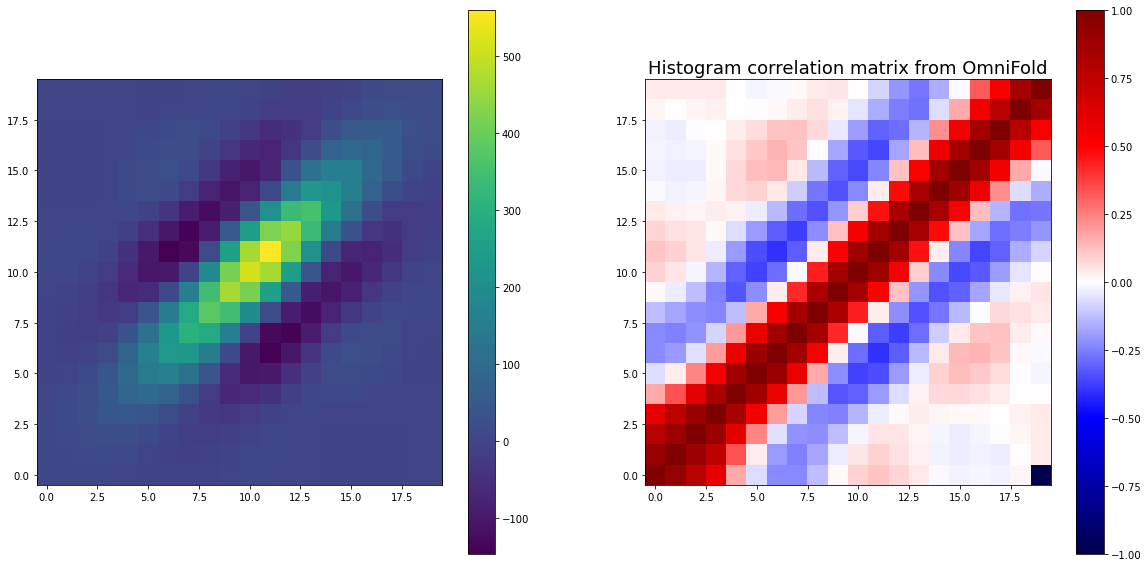

In [28]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [29]:
min_cov_element = np.min(hist_cov_mat)
max_cov_element = np.max(hist_cov_mat)
print('\n\n Min and max elements of cov mat:  %.2f , %.2f\n\n' % (min_cov_element, max_cov_element))
hist_cov_mat_copy = np.copy( hist_cov_mat )
hist_cov_mat_copy[0,hist_nbins-1] = -1. * max_cov_element



 Min and max elements of cov mat:  -146.47 , 560.08




<function matplotlib.pyplot.show(close=None, block=None)>

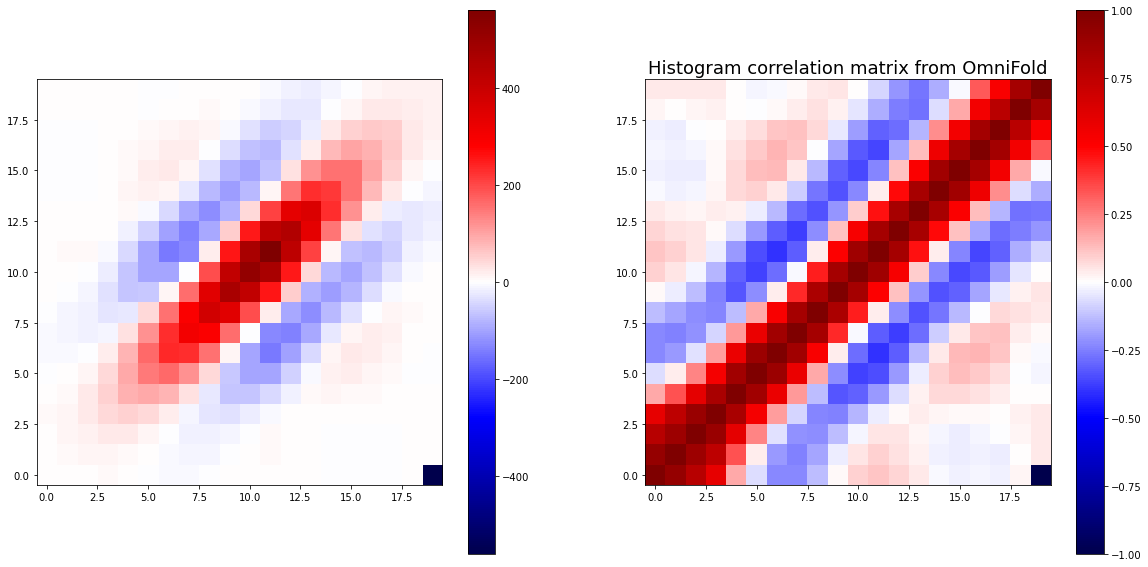

In [30]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [31]:
for bi in range(hist_nbins) :
    for bj in range(hist_nbins ) :
        
        calc_corr = hist_cov_mat[bi,bj] / np.sqrt( hist_cov_mat[bi,bi] * hist_cov_mat[bj,bj])
        
        print('  %2d, %2d :  histi  %10.2f   histj %10.2f  cov = %9.3f   cor = %9.4f  (%9.4f)' % 
              (bi, bj, boot_hist_content[0,bi], boot_hist_content[0,bj],
               hist_cov_mat[bi,bj], hist_corr_mat[bi,bj], calc_corr))



   0,  0 :  histi        4.08   histj       4.08  cov =     2.835   cor =    1.0000  (   1.0000)
   0,  1 :  histi        4.08   histj      11.30  cov =     3.276   cor =    0.9106  (   0.6856)
   0,  2 :  histi        4.08   histj      29.26  cov =     4.227   cor =    0.7765  (   0.6062)
   0,  3 :  histi        4.08   histj      71.39  cov =     5.092   cor =    0.5923  (   0.4707)
   0,  4 :  histi        4.08   histj     159.97  cov =     2.115   cor =    0.1715  (   0.1371)
   0,  5 :  histi        4.08   histj     311.95  cov =    -1.051   cor =   -0.0647  (  -0.0519)
   0,  6 :  histi        4.08   histj     525.45  cov =    -4.716   cor =   -0.2278  (  -0.1829)
   0,  7 :  histi        4.08   histj     776.41  cov =    -5.373   cor =   -0.2274  (  -0.1827)
   0,  8 :  histi        4.08   histj    1064.88  cov =    -3.334   cor =   -0.1265  (  -0.1017)
   0,  9 :  histi        4.08   histj    1242.19  cov =     0.338   cor =    0.0116  (   0.0093)
   0, 10 :  histi        4.08 

In [32]:
print('      ', end='')
for bj in range( hist_nbins ) :
    print('   %2d   ' % bj, end='')
print()

for bi in range( hist_nbins ) :
    print(' %2d : ' % bi, end='')
    for bj in range( hist_nbins ) :
        print( ' %6.3f ' % hist_corr_mat[bi,bj], end='')
    print()

          0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19   
  0 :   1.000   0.911   0.776   0.592   0.171  -0.065  -0.228  -0.227  -0.127   0.012   0.090   0.111   0.083   0.042  -0.012  -0.025  -0.021  -0.026   0.020  -1.000 
  1 :   0.911   1.000   0.878   0.753   0.338   0.032  -0.196  -0.247  -0.172  -0.039   0.053   0.087   0.062   0.024  -0.024  -0.038  -0.029  -0.035   0.005   0.040 
  2 :   0.776   0.878   1.000   0.891   0.599   0.239  -0.057  -0.211  -0.223  -0.131  -0.018   0.051   0.048   0.021  -0.023  -0.035  -0.023  -0.007   0.020   0.040 
  3 :   0.592   0.753   0.891   1.000   0.834   0.537   0.190  -0.081  -0.235  -0.245  -0.142  -0.039   0.014   0.035   0.019   0.009   0.010   0.007   0.024   0.043 
  4 :   0.171   0.338   0.599   0.834   1.000   0.860   0.571   0.200  -0.132  -0.333  -0.308  -0.195  -0.070   0.029   0.073   0.077   0.058   0.038   0.004   0.003

In [33]:
cov_det = np.linalg.det( hist_cov_mat )
print('\n\n Histogram covariance matrix determinant:  %9.4f\n\n' % cov_det)



 Histogram covariance matrix determinant:  433668566089719577837568.0000




In [34]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
print(hist_cov_inv)

[[ 7.40883218e-01 -1.79037429e-01 -1.18187077e-01 -5.01703827e-02
   8.84047815e-02 -1.36703803e-02 -1.38684988e-02 -4.29670229e-03
   1.18427044e-02 -4.06025547e-03  1.13885853e-03 -2.06949341e-03
   1.57297952e-05 -2.93458101e-03  7.03243891e-03 -6.26698154e-03
  -1.49144054e-03  5.33662948e-03 -8.82228707e-03  2.40365664e-03]
 [-1.79037429e-01  5.25293628e-01 -1.27402123e-01 -1.60553236e-01
   6.81985068e-02  2.08712130e-03  6.13786189e-03  1.17842730e-02
  -2.24406616e-02  1.96195330e-03  7.22364088e-03  5.05248296e-03
  -6.77814945e-03 -1.51555831e-03  1.70393051e-03  1.64871509e-03
  -5.44478410e-03  8.09794896e-03  6.75809946e-03 -7.63998697e-03]
 [-1.18187077e-01 -1.27402123e-01  3.87739680e-01 -1.26000805e-01
  -9.27011600e-02  5.70020430e-02  1.66943038e-02  1.04834396e-02
  -3.94302264e-02  1.33512767e-02  7.48521884e-03  3.56399892e-04
  -2.89659964e-03 -5.42184054e-03  3.59572911e-03  2.77168009e-03
   7.27982498e-03 -1.27222964e-02  2.24535263e-03  3.96128045e-03]
 [-5.01

In [35]:
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )
print( cov_inv_test)

[[ 1.00000000e+00 -1.40409174e-15 -4.45733409e-15 -2.94698853e-16
   6.78272768e-16 -2.14679692e-15 -1.01664967e-14 -1.46199732e-14
   1.56881042e-14  9.94818395e-17  1.08083857e-15 -1.10309118e-15
  -1.30359444e-15  1.93298254e-15  1.19648728e-15 -1.01138841e-15
  -1.26576040e-15  1.32955190e-16  4.98896631e-16  3.20026731e-16]
 [ 5.41349970e-16  1.00000000e+00 -1.98562751e-16 -3.51927904e-15
   1.52116000e-15 -1.80472126e-15  8.95260262e-15 -1.34668965e-15
  -5.34329875e-15  2.98308581e-15 -1.86251745e-15 -4.18717913e-16
   2.25924284e-15 -1.84141218e-15 -7.42027887e-16 -3.52213000e-17
   1.57848522e-16 -2.43170627e-16 -9.88895600e-17 -2.27479151e-17]
 [-9.80761458e-16 -4.56641086e-16  1.00000000e+00 -8.73137605e-16
  -2.47203477e-15 -4.95050646e-15 -1.15733239e-15 -4.15431524e-15
   5.02857663e-15 -4.72915973e-16 -5.83150517e-16 -4.72051758e-15
   1.76603529e-15 -1.51709740e-15  8.15807924e-16  1.33331871e-16
  -4.29271092e-16 -8.07695039e-16 -2.52748676e-17  6.31707650e-16]
 [ 7.74

<function matplotlib.pyplot.show(close=None, block=None)>

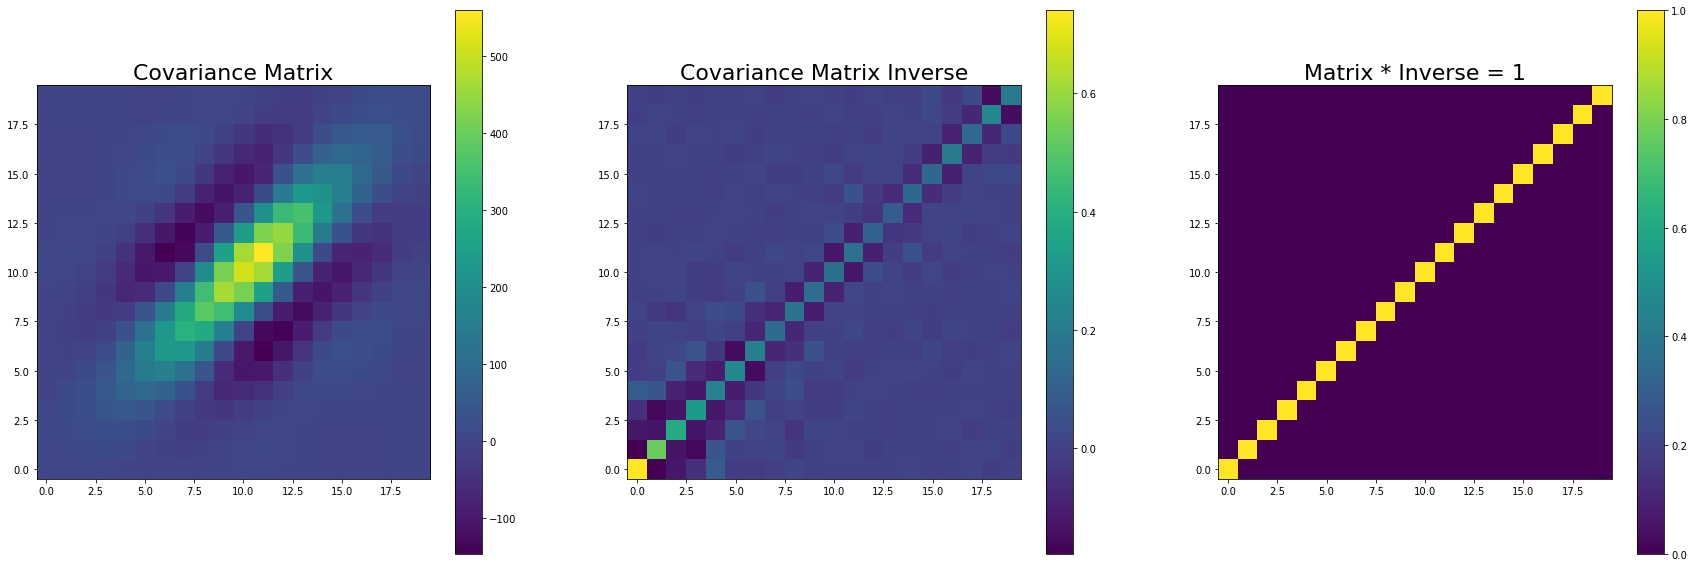

In [36]:
fig,ax = plt.subplots( 1, 3, figsize=(3*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im_covinv = ax[1].imshow(hist_cov_inv, origin='lower')
ax[1].figure.colorbar( im_covinv, ax=ax[1] )

im_covtest = ax[2].imshow(cov_inv_test, origin='lower')
ax[2].figure.colorbar( im_covtest, ax=ax[2] )

ax[0].set_title('Covariance Matrix', fontsize='22')
ax[1].set_title('Covariance Matrix Inverse', fontsize='22')
ax[2].set_title('Matrix * Inverse = 1', fontsize='22')

plt.show



In [37]:
ci_min = np.min(hist_cov_inv)
ci_max = np.max(hist_cov_inv)
print('\n\n min and max of covariance matrix inverse:  %.2f  %.2f\n\n' % (ci_min, ci_max))

hist_cov_inv_copy = np.copy( hist_cov_inv )
hist_cov_inv_copy[0,hist_nbins-1] = -1. * ci_max




 min and max of covariance matrix inverse:  -0.18  0.74




<function matplotlib.pyplot.show(close=None, block=None)>

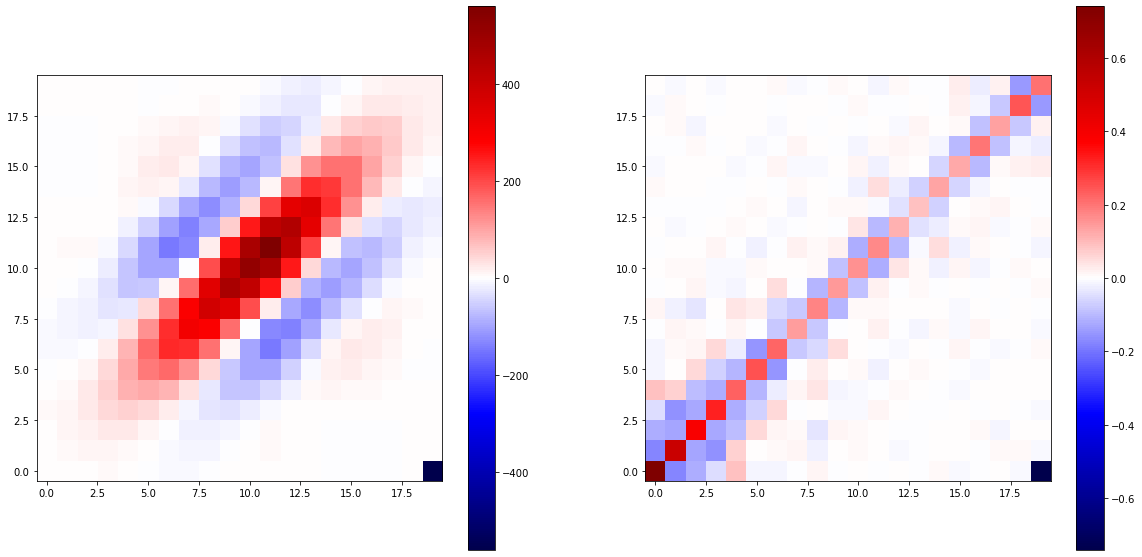

In [38]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [39]:
cov_mat_evals = np.linalg.eigvals( hist_cov_mat )

In [40]:
cov_mat_evals

array([1.63326424e+03, 1.25583693e+03, 6.50156297e+02, 3.01312595e+02,
       1.37734473e+02, 5.29356890e+01, 2.16185566e+01, 1.08200098e+01,
       7.38656113e+00, 6.17382951e+00, 5.00251922e+00, 1.16548271e+00,
       4.32727520e+00, 1.52204795e+00, 3.59464303e+00, 1.89197205e+00,
       3.23362616e+00, 2.72294375e+00, 2.43083044e+00, 2.48255914e+00])

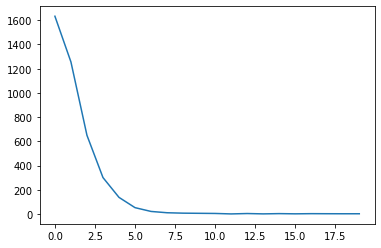

In [41]:
plt.plot(cov_mat_evals)

In [42]:
U, S, Vh = np.linalg.svd( hist_cov_mat, full_matrices=True)

In [43]:
U.shape

(20, 20)

In [44]:
S.shape

(20,)

In [45]:
Vh.shape

(20, 20)

In [46]:
S

array([1.63326424e+03, 1.25583693e+03, 6.50156297e+02, 3.01312595e+02,
       1.37734473e+02, 5.29356890e+01, 2.16185566e+01, 1.08200098e+01,
       7.38656113e+00, 6.17382951e+00, 5.00251922e+00, 4.32727520e+00,
       3.59464303e+00, 3.23362616e+00, 2.72294375e+00, 2.48255914e+00,
       2.43083044e+00, 1.89197205e+00, 1.52204795e+00, 1.16548271e+00])

In [47]:
U

array([[-3.43845490e-03, -4.44798793e-03, -6.62104292e-03,
        -5.92368275e-03,  3.98515808e-02, -1.07221729e-01,
        -1.14464270e-01, -1.20544813e-01,  6.95924921e-02,
         1.16187840e-01,  9.10404006e-02, -1.72857713e-01,
         1.38912881e-01, -1.42927515e-01,  2.18725720e-02,
         5.60822054e-02,  8.65967131e-02, -1.60446114e-01,
        -2.37080857e-01,  8.77418291e-01],
       [-3.85897303e-03, -1.02830225e-02, -1.29104525e-02,
        -2.73559750e-02,  1.00516226e-01, -2.38885789e-01,
        -2.10346223e-01, -2.00092847e-01,  1.03754006e-01,
         1.53856130e-01,  1.35817517e-01, -2.53496797e-01,
         1.88747825e-01, -1.52425589e-01, -1.43740123e-02,
         3.01522373e-03,  5.90683918e-02, -2.26409645e-03,
        -6.94787187e-01, -4.30197231e-01],
       [ 1.97317530e-03, -1.80610477e-02, -8.17484664e-03,
        -8.29255438e-02,  1.93373206e-01, -3.37437211e-01,
        -2.48310145e-01, -2.18818424e-01,  4.59323311e-02,
         1.46008657e-01,  1.2

In [48]:
U[:,0]

array([-0.00343845, -0.00385897,  0.00197318,  0.02379308,  0.07512297,
        0.12990305,  0.15624595,  0.09408217, -0.09373626, -0.34801191,
       -0.52143396, -0.56939339, -0.40936586, -0.18950972, -0.00417686,
        0.07110058,  0.07637076,  0.05282228,  0.01867103,  0.00902296])

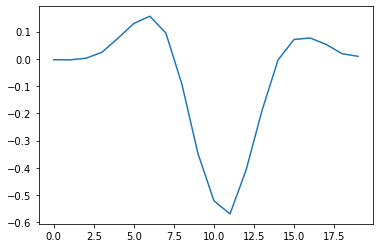

In [49]:
plt.plot(U[:,0])

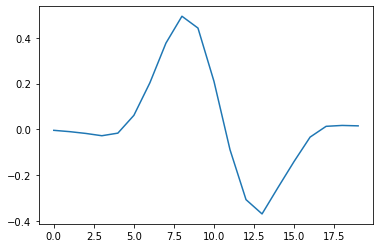

In [50]:
plt.plot(U[:,1])

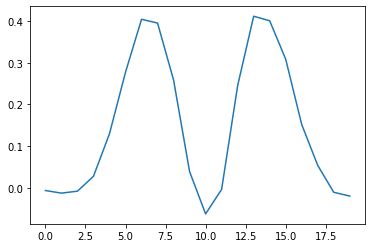

In [51]:
plt.plot(U[:,2])

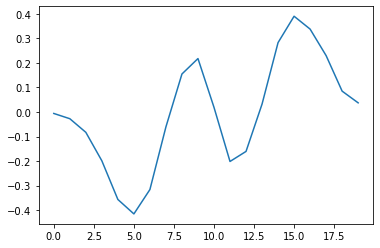

In [52]:
plt.plot(U[:,3])

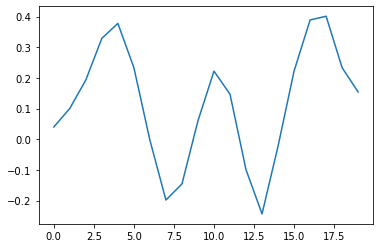

In [53]:
plt.plot(U[:,4])

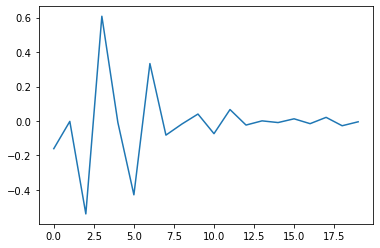

In [54]:
plt.plot(U[:,17])

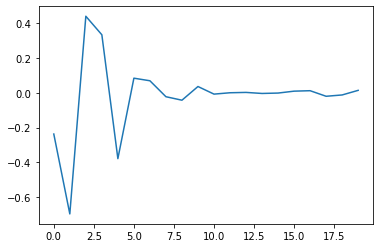

In [55]:
plt.plot(U[:,18])

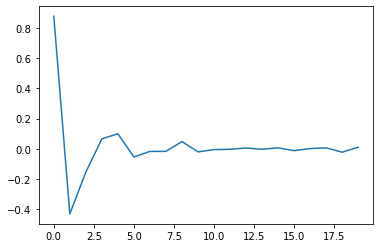

In [56]:
plt.plot(U[:,19])

(-50.0, 50.0)

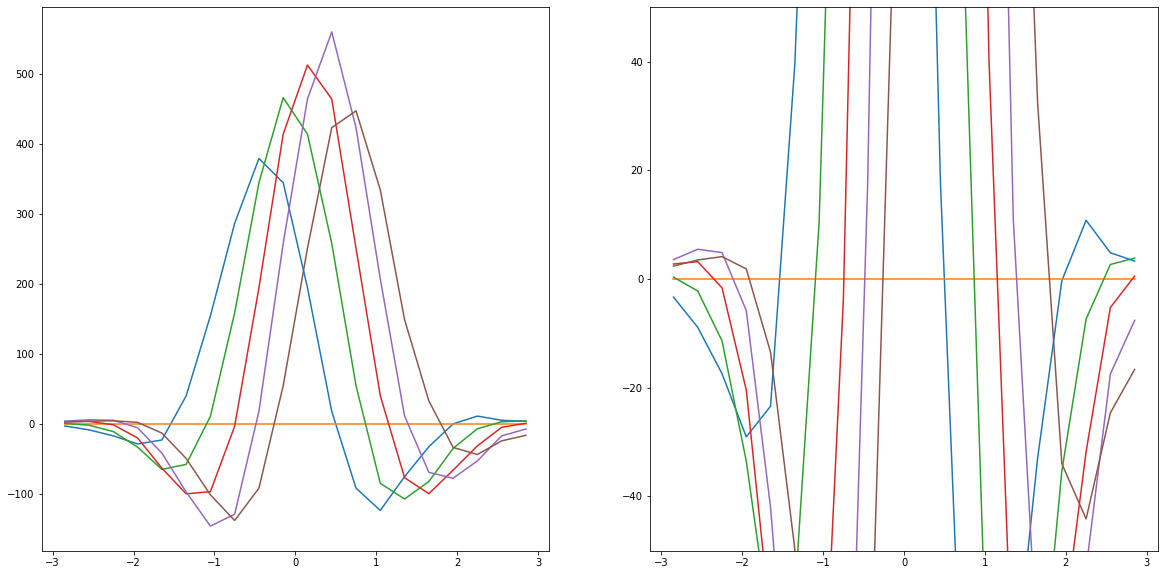

In [57]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[0].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[12,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[1].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[12,:] )


ax[1].set_ylim([-50,50])

(-50.0, 50.0)

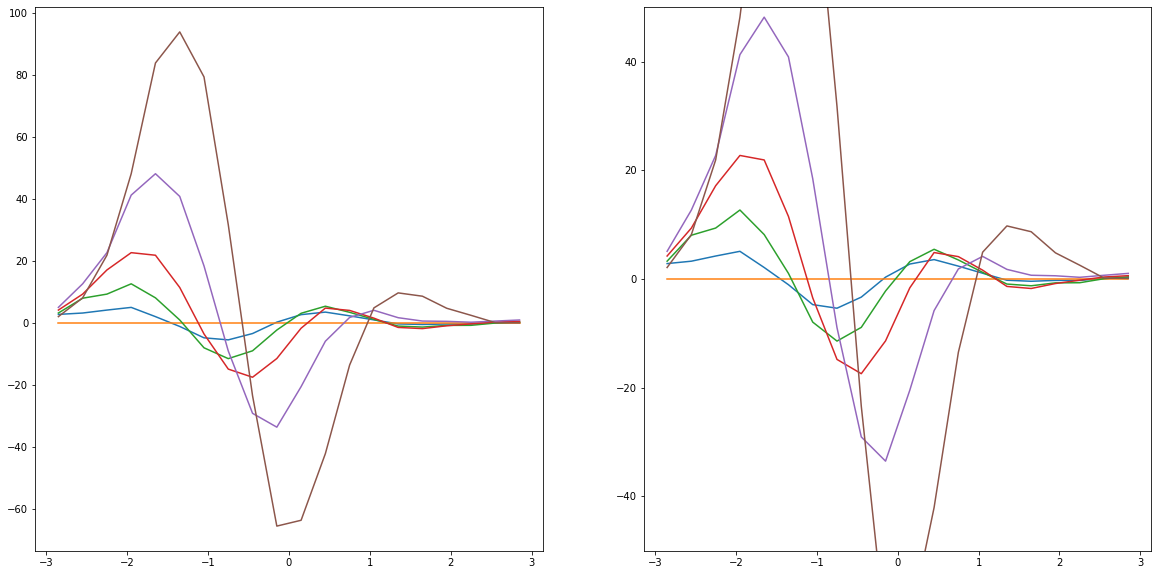

In [58]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[4,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[4,:] )


ax[1].set_ylim([-50,50])

## Try using the pseudo inverse of the covariance matrix for the chi2

In [59]:

#--- off
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat )


#--- not enough?
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.0001 )

#--- ok
hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.01 )

#-- probably too much
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.05 )


print(hist_cov_pinv)

[[ 4.34016722e-02  3.66077889e-02  6.57760209e-02 -4.83406588e-02
  -4.56888978e-02  3.97148023e-02  9.36731074e-03  4.53845560e-03
  -3.12760097e-02  1.62959988e-02  3.38575219e-03 -2.89862762e-05
  -4.32772424e-03 -1.75366886e-03  1.47772087e-03  3.74119192e-03
  -1.32704762e-03 -2.90922817e-03  5.60239702e-03 -3.71507854e-03]
 [ 3.66077889e-02  4.93436428e-02  1.57657633e-02  1.53215678e-02
  -6.75119011e-02  2.01603543e-02  3.10995985e-02 -4.90882595e-03
  -2.42873084e-02  1.07772000e-02  1.70931255e-03  3.78360136e-03
  -3.84982637e-03 -4.49805337e-03  3.23141362e-03  1.35227576e-03
   4.78263761e-04  1.13582533e-03 -7.29520278e-03  2.43703323e-03]
 [ 6.57760209e-02  1.57657633e-02  2.41441565e-01 -2.12723305e-01
   2.92625102e-02  2.60202796e-02 -5.14627509e-03  1.49771707e-02
  -2.06388972e-02  5.97361850e-04  9.24831822e-03  1.30050308e-04
  -2.52591798e-03 -4.45399523e-03  5.15362696e-03 -1.23553496e-03
   4.31657882e-03 -5.89840417e-03  3.12987823e-03  1.57436367e-03]
 [-4.83

In [60]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv

In [61]:
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

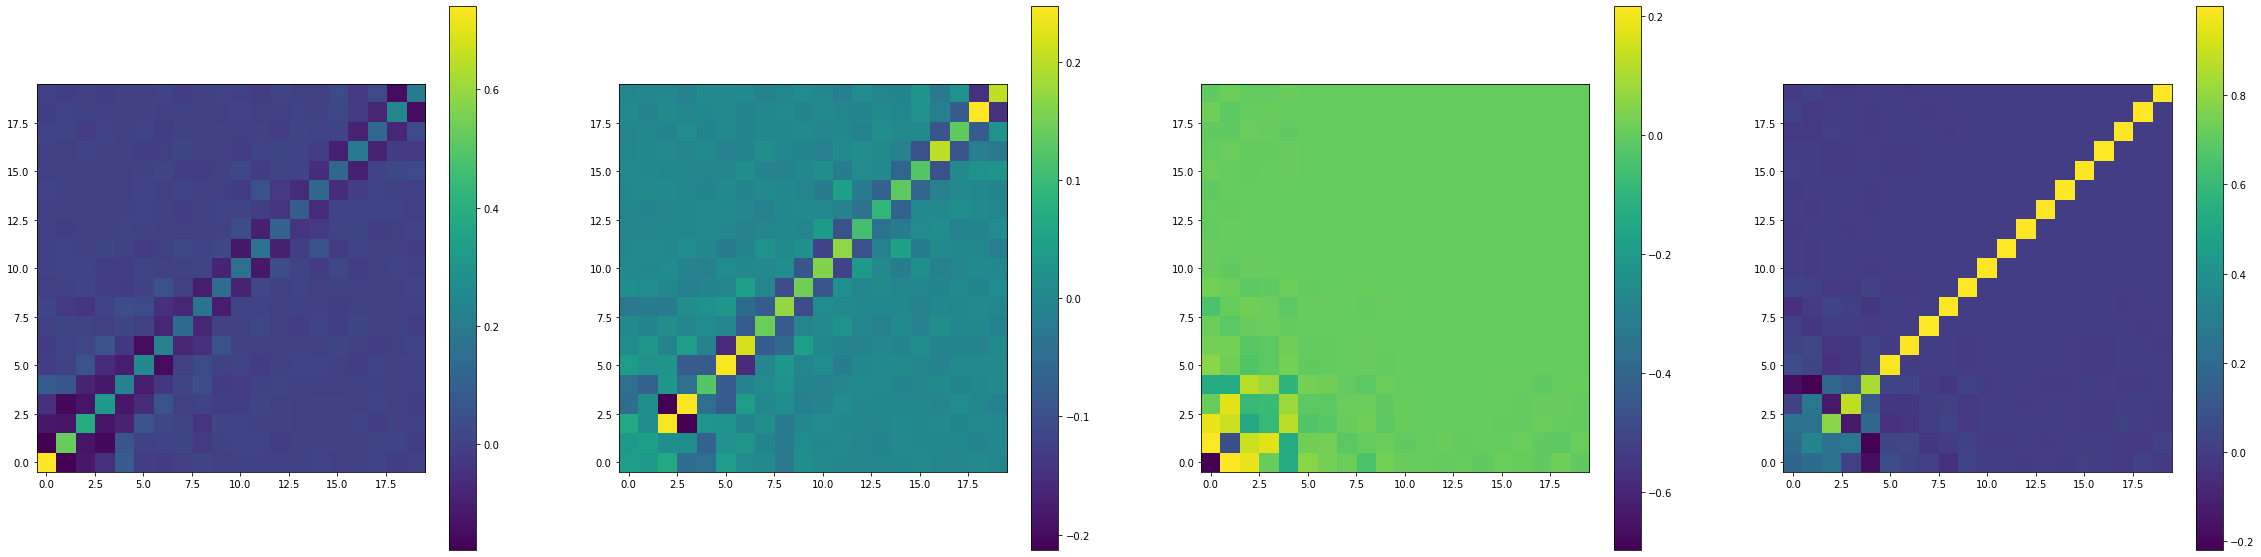

In [62]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [63]:
cpi_min = np.min(hist_cov_pinv)
cpi_max = np.max(hist_cov_pinv)
print('\n\n min and max of covariance matrix pseudo inverse:  %.2f  %.2f\n\n' % (cpi_min, cpi_max))

hist_cov_pinv_copy = np.copy( hist_cov_pinv )
hist_cov_pinv_copy[0,hist_nbins-1] = -1. * cpi_max




 min and max of covariance matrix pseudo inverse:  -0.21  0.25




In [64]:
for bi in range( hist_nbins ) :
    print('bin %3d : x = %7.2f  diagonal,  cov inv %10.5f,  cov pinv %10.5f  ' %(
    bi, hist_bin_centers[bi], hist_cov_inv[bi,bi], hist_cov_pinv[bi,bi]))

bin   0 : x =   -2.85  diagonal,  cov inv    0.74088,  cov pinv    0.04340  
bin   1 : x =   -2.55  diagonal,  cov inv    0.52529,  cov pinv    0.04934  
bin   2 : x =   -2.25  diagonal,  cov inv    0.38774,  cov pinv    0.24144  
bin   3 : x =   -1.95  diagonal,  cov inv    0.32080,  cov pinv    0.24473  
bin   4 : x =   -1.65  diagonal,  cov inv    0.22905,  cov pinv    0.12658  
bin   5 : x =   -1.35  diagonal,  cov inv    0.24931,  cov pinv    0.24230  
bin   6 : x =   -1.05  diagonal,  cov inv    0.22083,  cov pinv    0.21753  
bin   7 : x =   -0.75  diagonal,  cov inv    0.14374,  cov pinv    0.14316  
bin   8 : x =   -0.45  diagonal,  cov inv    0.17476,  cov pinv    0.17154  
bin   9 : x =   -0.15  diagonal,  cov inv    0.14911,  cov pinv    0.14796  
bin  10 : x =    0.15  diagonal,  cov inv    0.15942,  cov pinv    0.15936  
bin  11 : x =    0.45  diagonal,  cov inv    0.16874,  cov pinv    0.16873  
bin  12 : x =    0.75  diagonal,  cov inv    0.11137,  cov pinv    0.11134  

<function matplotlib.pyplot.show(close=None, block=None)>

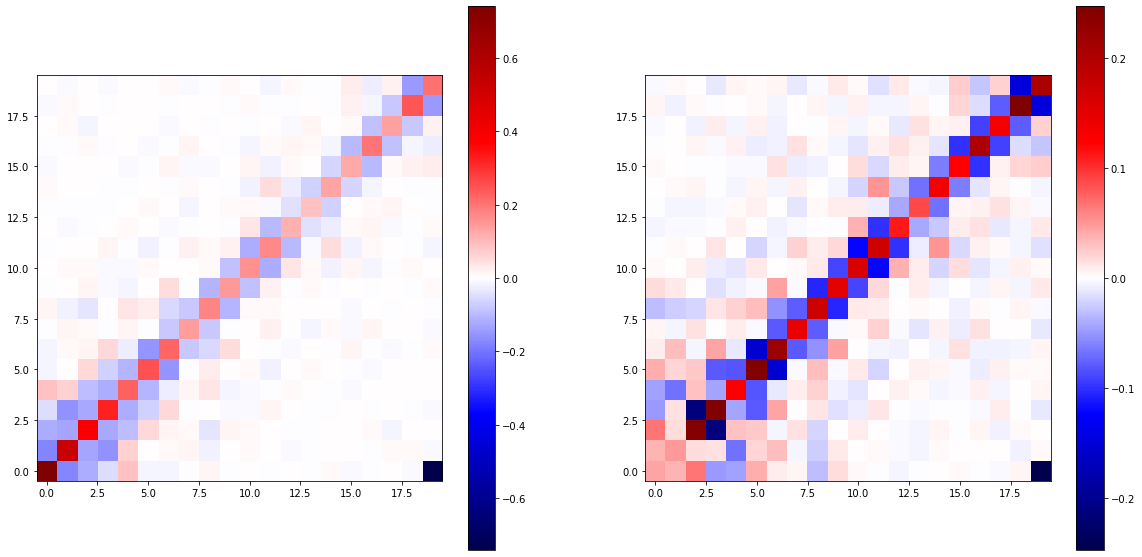

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_pinv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [66]:
hist_cov_inv[:,10]

array([ 0.00113886,  0.00722364,  0.00748522, -0.01012127, -0.0102741 ,
        0.01041188,  0.00074351,  0.00314002,  0.01028201, -0.08995336,
        0.15941986, -0.12032445,  0.03790835,  0.00801056, -0.01978042,
        0.01704784, -0.01302471, -0.0038292 ,  0.00743985,  0.00221738])

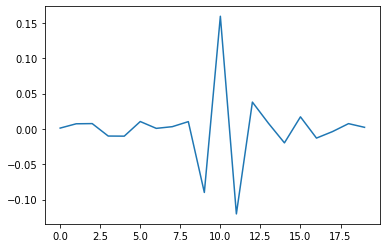

In [67]:
plt.plot(hist_cov_inv[:,10])
#plt.plot(hist_cov_inv[:,11])
#plt.plot(hist_cov_inv[:,12])

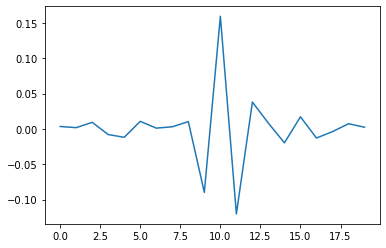

In [68]:
plt.plot(hist_cov_pinv[:,10])
#plt.plot(hist_cov_pinv[:,11])
#plt.plot(hist_cov_pinv[:,12])

In [69]:
for bi in range( hist_nbins ) :
    for bj in range( hist_nbins ) :
        print('  %3d, %3d:   inv = %8.3f   pinv = %8.3f' % (bi, bj, hist_cov_inv[bi,bj], hist_cov_pinv[bi,bj]))

    0,   0:   inv =    0.741   pinv =    0.043
    0,   1:   inv =   -0.179   pinv =    0.037
    0,   2:   inv =   -0.118   pinv =    0.066
    0,   3:   inv =   -0.050   pinv =   -0.048
    0,   4:   inv =    0.088   pinv =   -0.046
    0,   5:   inv =   -0.014   pinv =    0.040
    0,   6:   inv =   -0.014   pinv =    0.009
    0,   7:   inv =   -0.004   pinv =    0.005
    0,   8:   inv =    0.012   pinv =   -0.031
    0,   9:   inv =   -0.004   pinv =    0.016
    0,  10:   inv =    0.001   pinv =    0.003
    0,  11:   inv =   -0.002   pinv =   -0.000
    0,  12:   inv =    0.000   pinv =   -0.004
    0,  13:   inv =   -0.003   pinv =   -0.002
    0,  14:   inv =    0.007   pinv =    0.001
    0,  15:   inv =   -0.006   pinv =    0.004
    0,  16:   inv =   -0.001   pinv =   -0.001
    0,  17:   inv =    0.005   pinv =   -0.003
    0,  18:   inv =   -0.009   pinv =    0.006
    0,  19:   inv =    0.002   pinv =   -0.004
    1,   0:   inv =   -0.179   pinv =    0.037
    1,   1:  

In [70]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [71]:
hist_cov_mat_diagonal

array([[  2.83518103,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   8.05186066,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  17.15328509,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  

In [72]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )
print(hist_cov_inv_diagonal)

[[0.35271116 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.1241949  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.05829787 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.02422752 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.01192514 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


In [73]:
diagonal_hist_sigma2 = np.zeros( shape=(hist_nbins) )
for bi in range( hist_nbins ) :
    diagonal_hist_sigma2[bi] = hist_cov_mat_diagonal[bi,bi]
diagonal_hist_sigma = np.sqrt( diagonal_hist_sigma2 )

In [74]:
diagonal_hist_sigma

array([ 1.68379958,  2.83758007,  4.14165246,  6.4245911 ,  9.15731646,
       12.03255174, 15.31153129, 17.46558185, 19.47152187, 21.59000468,
       22.6433107 , 23.66602782, 21.14712787, 18.854118  , 14.6880308 ,
       12.43427182,  9.22326244,  7.43885912,  4.6329972 ,  3.89900357])

In [75]:
sqrtn_from_hist = np.sqrt( unfolded_hist )

In [76]:
sqrtn_from_hist

array([ 2.82663006,  4.2590137 ,  5.77271245,  8.98128501, 12.71602015,
       17.84232209, 22.73813099, 27.34013043, 31.99065829, 34.57239974,
       35.54669226, 35.39149758, 33.30282021, 29.52533867, 24.0251764 ,
       19.27926479, 13.93391354, 10.00011199,  6.09011905,  4.58031865])

In [77]:
err_ratio = diagonal_hist_sigma / sqrtn_from_hist

In [78]:
err_ratio

array([0.59569153, 0.66625286, 0.71745345, 0.71533095, 0.72014013,
       0.67438261, 0.67338566, 0.63882584, 0.60866274, 0.62448672,
       0.63700191, 0.66869247, 0.63499511, 0.63857415, 0.61135996,
       0.64495571, 0.66192907, 0.74387758, 0.76074   , 0.8512516 ])

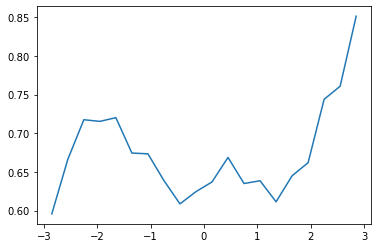

In [79]:
plt.plot( hist_bin_centers, err_ratio )

<ErrorbarContainer object of 3 artists>

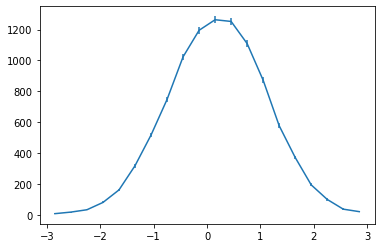

In [80]:
plt.errorbar( hist_bin_centers, unfolded_hist, diagonal_hist_sigma )

In [81]:
boot_hist_content

array([[  4.08078351,  11.30478049,  29.25515245, ..., 115.93337954,
         42.84514277,  22.4564266 ],
       [  5.50543216,  15.69487905,  35.00644261, ..., 111.18321681,
         46.19081869,  24.43407476],
       [  5.69608918,  15.59629088,  38.17116371, ..., 115.8966245 ,
         42.28093542,  19.16327924],
       ...,
       [  7.65070915,  18.57054285,  40.80315259, ..., 127.4485146 ,
         51.23384575,  25.41508085],
       [  5.18497091,  15.89605958,  34.05495586, ..., 105.09915149,
         38.10180752,  19.5832336 ],
       [  7.12267186,  16.74047946,  39.86301512, ..., 107.90759275,
         37.61712942,  18.72292478]])

In [82]:
np.sum(boot_hist_content, axis=1)

array([ 9984.18085552,  9984.18788645,  9961.81257178, 10032.8195221 ,
       10176.01043198,  9945.97983222,  9882.74480468,  9893.26364787,
        9925.60694063, 10196.5515832 ,  9973.65910638,  9822.50385851,
        9897.3149795 , 10010.14698427, 10053.78984661,  9929.38610516,
        9973.09651476,  9971.51088784, 10001.40328992, 10029.92935924,
        9850.6748237 ,  9857.41353941, 10054.73536641,  9887.53456147,
        9904.94932778,  9920.29119246,  9960.00456068,  9913.32936144,
        9797.89953405, 10039.26356069,  9887.79642005,  9912.31767063,
        9990.18928028,  9921.21166245, 10000.01606462, 10046.15951028,
        9990.89745841,  9981.27456415,  9867.71114373,  9791.59459067,
        9960.22891291, 10015.4430638 ,  9823.62409527,  9977.34954738,
        9965.69842438, 10238.11694582,  9908.22381524, 10083.73978269,
       10148.25421628,  9797.3961413 , 10031.0396511 , 10051.03967476,
       10019.53447269,  9982.58074783,  9908.1668248 ,  9903.69734855,
      

(array([  1.,   2.,  13.,  57.,  96., 122.,  96.,  70.,  29.,  14.]),
 array([ 9604.05490511,  9667.46110918,  9730.86731325,  9794.27351732,
         9857.67972139,  9921.08592546,  9984.49212953, 10047.89833361,
        10111.30453768, 10174.71074175, 10238.11694582]),
 <BarContainer object of 10 artists>)

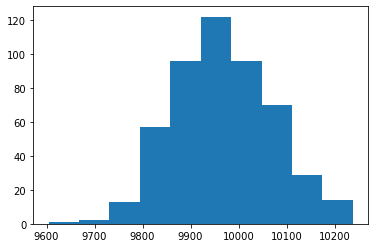

In [83]:
plt.hist(np.sum(boot_hist_content, axis=1))

(array([  1.,   2.,  18.,  58.,  97., 125.,  97.,  62.,  27.,  13.]),
 array([ 9622.49662732,  9685.89841303,  9749.30019873,  9812.70198444,
         9876.10377014,  9939.50555585, 10002.90734155, 10066.30912726,
        10129.71091296, 10193.11269867, 10256.51448437]),
 <BarContainer object of 10 artists>)

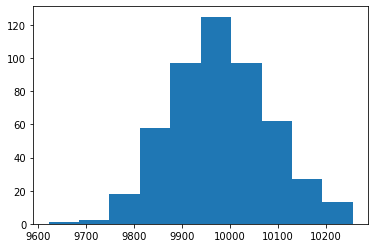

In [84]:
plt.hist(of_weight_sum)

In [85]:
model_mu = 0.2
model_sigma = 0.90
model_cov = model_sigma * model_sigma

hist_sum = np.sum( unfolded_hist )

model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt(  2 * 3.14159265 ) )

model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )




<function matplotlib.pyplot.show(close=None, block=None)>

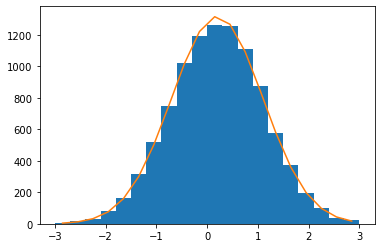

In [86]:

plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )
plt.plot( hist_bin_centers, model_pred )



plt.show

In [87]:
weight_sum

9913.400685558838

In [88]:
np.sum(unfolded_hist)

9901.393821735088

In [89]:
for bi in range( hist_nbins ) :
    diff = unfolded_hist[bi] - model_pred[bi]
    print(' %3d : x = %5.2f  model = %8.1f  hist = %8.1f  diff = %8.1f   sqrt(covii) = %8.1f' % 
          (bi, hist_bin_centers[bi], model_pred[bi], unfolded_hist[bi], diff, np.sqrt(hist_cov_mat[bi,bi]) ))

   0 : x = -2.85  model =      4.2  hist =      8.0  diff =      3.8   sqrt(covii) =      1.7
   1 : x = -2.55  model =     12.4  hist =     18.1  diff =      5.8   sqrt(covii) =      2.8
   2 : x = -2.25  model =     32.4  hist =     33.3  diff =      0.9   sqrt(covii) =      4.1
   3 : x = -1.95  model =     75.9  hist =     80.7  diff =      4.8   sqrt(covii) =      6.4
   4 : x = -1.65  model =    159.2  hist =    161.7  diff =      2.5   sqrt(covii) =      9.2
   5 : x = -1.35  model =    298.8  hist =    318.3  diff =     19.5   sqrt(covii) =     12.0
   6 : x = -1.05  model =    501.9  hist =    517.0  diff =     15.1   sqrt(covii) =     15.3
   7 : x = -0.75  model =    754.3  hist =    747.5  diff =     -6.8   sqrt(covii) =     17.5
   8 : x = -0.45  model =   1014.4  hist =   1023.4  diff =      9.0   sqrt(covii) =     19.5
   9 : x = -0.15  model =   1220.8  hist =   1195.3  diff =    -25.6   sqrt(covii) =     21.6
  10 : x =  0.15  model =   1314.7  hist =   1263.6  diff = 

In [90]:
dy = unfolded_hist - model_pred
    
cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)

cov_pinv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
dy_times_cov_pinv_times_dy =  np.sum( dy.T * cov_pinv_times_dy, axis=0)
    
this_chi2 = dy_times_cov_inv_times_dy

this_chi2_pinv = dy_times_cov_pinv_times_dy

print('\n\n chi2 = %10.3f, with pseudoinverse = %10.3f\n\n' % (this_chi2, this_chi2_pinv) )



 chi2 =    355.289, with pseudoinverse =    351.588




In [91]:
cov_inv_diagonal_times_dy = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )


In [92]:
dy

array([  3.76662521,   5.77666779,   0.94122563,   4.75830008,
         2.48691552,  19.52429833,  15.13618963,  -6.81052686,
         8.97691621, -25.55045875, -51.09717711, -14.30578963,
        16.65684846,  28.8085236 ,  -4.82088574,  12.07272262,
        -4.6755977 ,   1.63142206,  -6.46130675,   3.72601853])

In [93]:
cov_inv_times_dy

array([ 1.24798426,  0.82790368, -1.67757255,  0.14245526, -0.51773058,
        2.23329668, -0.37321946, -3.94515267,  3.86778395,  0.57795329,
       -2.68319117,  0.42388585,  0.34422097,  1.91379294, -3.31428624,
        2.01854252, -1.41343501,  1.62680051, -2.06586298,  2.24180007])

<function matplotlib.pyplot.show(close=None, block=None)>

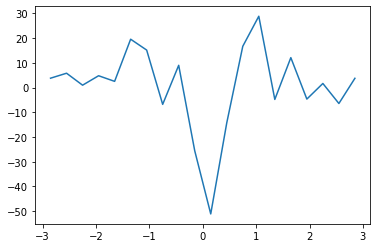

In [94]:
plt.plot( hist_bin_centers, dy )
plt.show

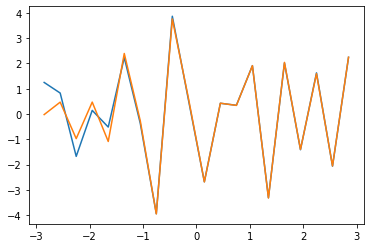

In [95]:
plt.plot( hist_bin_centers, cov_inv_times_dy )
plt.plot( hist_bin_centers, cov_pinv_times_dy )

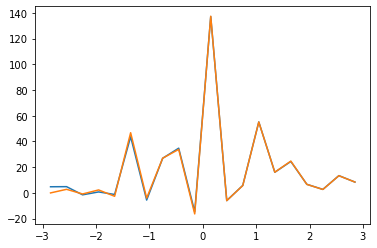

In [96]:
plt.plot( hist_bin_centers, dy.T * cov_inv_times_dy )
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )

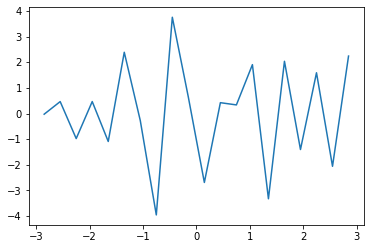

In [97]:
plt.plot( hist_bin_centers, cov_pinv_times_dy )

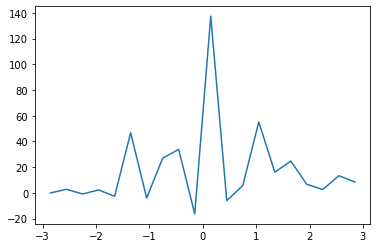

In [98]:
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )

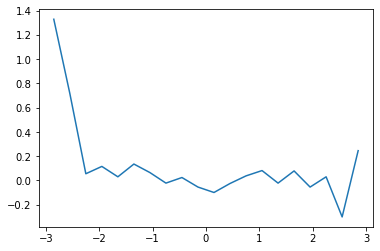

In [99]:
plt.plot( hist_bin_centers, cov_inv_diagonal_times_dy )

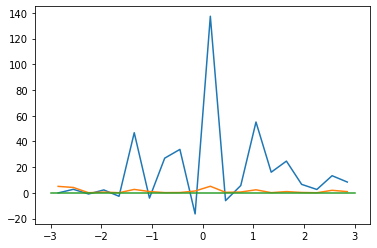

In [100]:
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )
plt.plot( hist_bin_centers, dy.T * cov_inv_diagonal_times_dy )
plt.plot( [-3,3], [0,0])

In [101]:
n_scan_points = 10

scan_min = 0.0
scan_max = 0.4

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = scan_par_vals[si]
    model_sigma = 0.9
    model_cov = model_sigma * model_sigma

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.000  chi2 =          619.34,   diagonal chi2 =         1052.10
 scan point   1  par   0.044  chi2 =          504.26,   diagonal chi2 =          637.63
 scan point   2  par   0.089  chi2 =          421.28,   diagonal chi2 =          331.68
 scan point   3  par   0.133  chi2 =          369.87,   diagonal chi2 =          131.75
 scan point   4  par   0.178  chi2 =          349.83,   diagonal chi2 =           36.42
 scan point   5  par   0.222  chi2 =          361.25,   diagonal chi2 =           45.30
 scan point   6  par   0.267  chi2 =          404.54,   diagonal chi2 =          158.95
 scan point   7  par   0.311  chi2 =          480.35,   diagonal chi2 =          378.84
 scan point   8  par   0.356  chi2 =          589.63,   diagonal chi2 =          707.37
 scan point   9  par   0.400  chi2 =          733.57,   diagonal chi2 =         1147.74


<function matplotlib.pyplot.show(close=None, block=None)>

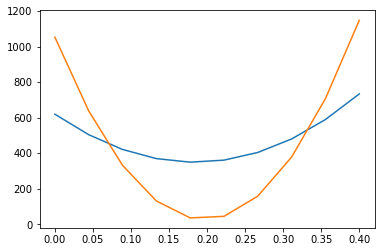

In [102]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [103]:
n_scan_points = 10

scan_min = 0.7
scan_max = 0.9

#scan_min = 0.78
#scan_max = 0.84

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )


for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = 0.2
    model_sigma = np.sqrt( scan_par_vals[si] )
    model_cov = scan_par_vals[si]

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )

    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy
    
    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
     
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.700  chi2 =          418.01,   diagonal chi2 =          277.72
 scan point   1  par   0.722  chi2 =          396.04,   diagonal chi2 =          194.98
 scan point   2  par   0.744  chi2 =          378.65,   diagonal chi2 =          129.37
 scan point   3  par   0.767  chi2 =          365.57,   diagonal chi2 =           80.03
 scan point   4  par   0.789  chi2 =          356.55,   diagonal chi2 =           46.21
 scan point   5  par   0.811  chi2 =          351.42,   diagonal chi2 =           27.22
 scan point   6  par   0.833  chi2 =          350.02,   diagonal chi2 =           22.45
 scan point   7  par   0.856  chi2 =          352.22,   diagonal chi2 =           31.34
 scan point   8  par   0.878  chi2 =          357.92,   diagonal chi2 =           53.39
 scan point   9  par   0.900  chi2 =          367.04,   diagonal chi2 =           88.13


<function matplotlib.pyplot.show(close=None, block=None)>

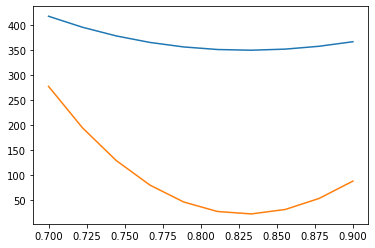

In [104]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [105]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

xMin = hist_xlow
xMax = hist_xhigh

In [106]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

In [107]:
# Initialize Minuit and set up fit:
theta = 1
mu = 0.2
sigma2 = 0.81
#fitType = 'bin center approximation'
#fitType = 'integral within bin'

parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
parname = ['theta', 'mu', 'sigma2']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
parfix  = [False, False, False]            # change to fix/free param.
parlim  = [(0.5, 1.5), (None, None), (0., None)]

chisq = ChiSquared(unfolded_hist, hist_bin_edges, hist_cov_pinv, fitType, 1)
chisq_diag = ChiSquared(unfolded_hist, hist_bin_edges, hist_cov_inv_diagonal, fitType, 1)


m = Minuit(chisq, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 1.0                      # errors from chi2 = chi2min + 1


m_diag = Minuit(chisq_diag, parin, name=parname)
m_diag.errors = parstep
m_diag.fixed = parfix
m_diag.limits = parlim
m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1



 setData:
  numVal:       9901.4  numBins = 20
  binLowEdge:   fitType: integral within bin
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


 setData:
  numVal:       9901.4  numBins = 20
  binLowEdge:   fitType: integral within bin
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


In [108]:
# do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
parhat = m.values                                 # max-likelihood estimates
sigma_parhat = m.errors                           # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

m_diag.migrad()                                        # minimize -logL
parhat_diag = m_diag.values                                 # max-likelihood estimates
sigma_parhat_diag = m_diag.errors                           # standard deviations
cov_diag = m_diag.covariance                                # covariance matrix
rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.




In [109]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:

        print(' %2d %-10s  =  %7.4f +/- %7.4f ,   diagonal cov result = %7.4f +/- %7.4f' %
              (i, m.parameters[i], parhat[i], sigma_parhat[i],
              parhat_diag[i], sigma_parhat_diag[i])
             )
            
            
            
print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not m.fixed[i]:
        for j in range(m.npar):
            if not m.fixed[j]:
                print(i, j, "{:9.6f}".format(cov[i,j]), "{:9.6f}".format(rho[i,j]))

# Retrieve minimized chi-squared, etc.
ndof = hist_nbins - m.nfit - 1           # for fixed numVal
chi2min = chisq(parhat)
print ("chi2min = ", chi2min, ",     ndof = ", ndof)
pval = chi2.sf(chi2min, ndof)
print ("pval = ", pval)

par index, name, estimate, standard deviation:
  0 theta       =   0.9658 +/-  0.0100 ,   diagonal cov result =  1.0006 +/-  0.0065
  1 mu          =   0.1846 +/-  0.0115 ,   diagonal cov result =  0.1957 +/-  0.0061
  2 sigma2      =   0.8235 +/-  0.0170 ,   diagonal cov result =  0.8226 +/-  0.0085

free par indices, covariance, correlation coeff.:
0 0  0.000100  1.000000
0 1 -0.000003 -0.028717
0 2  0.000001  0.008651
1 0 -0.000003 -0.028717
1 1  0.000133  1.000000
1 2 -0.000004 -0.021292
2 0  0.000001  0.008651
2 1 -0.000004 -0.021292
2 2  0.000288  1.000000
chi2min =  336.02905056555824 ,     ndof =  16
pval =  8.425236032646106e-62


In [110]:
n_scan_points = 40

scan_min = parhat[1] - 2*sigma_parhat[1]
scan_max = parhat[1] + 2*sigma_parhat[1]

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = scan_par_vals[si]
    model_sigma = 0.9
    model_cov = model_sigma * model_sigma

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.162  chi2 =          353.52,   diagonal chi2 =           59.19
 scan point   1  par   0.163  chi2 =          353.11,   diagonal chi2 =           57.06
 scan point   2  par   0.164  chi2 =          352.72,   diagonal chi2 =           55.01
 scan point   3  par   0.165  chi2 =          352.35,   diagonal chi2 =           53.03
 scan point   4  par   0.166  chi2 =          352.01,   diagonal chi2 =           51.13
 scan point   5  par   0.167  chi2 =          351.69,   diagonal chi2 =           49.30
 scan point   6  par   0.169  chi2 =          351.39,   diagonal chi2 =           47.54
 scan point   7  par   0.170  chi2 =          351.11,   diagonal chi2 =           45.86
 scan point   8  par   0.171  chi2 =          350.86,   diagonal chi2 =           44.25
 scan point   9  par   0.172  chi2 =          350.63,   diagonal chi2 =           42.71
 scan point  10  par   0.173  chi2 =          350.42,   diagonal chi2 =           41.25
 scan point  11  par   0.175  ch

<function matplotlib.pyplot.show(close=None, block=None)>

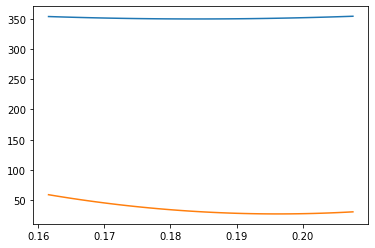

In [111]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [112]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals[si] < min_chi2 :
        min_chi2 = scan_chi2_vals[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals[si] - scan_chi2_vals[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals[si], dx, dchi2)
         )


  point for min chi2 :   19  val = 349.527
   0 :  x =   0.1615  chi2 =     353.52   dx = -0.0225  dchi2 =  3.9914
   1 :  x =   0.1627  chi2 =     353.11   dx = -0.0213  dchi2 =  3.5814
   2 :  x =   0.1639  chi2 =     352.72   dx = -0.0201  dchi2 =  3.1936
   3 :  x =   0.1651  chi2 =     352.35   dx = -0.0189  dchi2 =  2.8280
   4 :  x =   0.1663  chi2 =     352.01   dx = -0.0177  dchi2 =  2.4846
   5 :  x =   0.1674  chi2 =     351.69   dx = -0.0165  dchi2 =  2.1634
   6 :  x =   0.1686  chi2 =     351.39   dx = -0.0154  dchi2 =  1.8644
   7 :  x =   0.1698  chi2 =     351.11   dx = -0.0142  dchi2 =  1.5876
   8 :  x =   0.1710  chi2 =     350.86   dx = -0.0130  dchi2 =  1.3331
   9 :  x =   0.1722  chi2 =     350.63   dx = -0.0118  dchi2 =  1.1007
  10 :  x =   0.1734  chi2 =     350.42   dx = -0.0106  dchi2 =  0.8906
  11 :  x =   0.1745  chi2 =     350.23   dx = -0.0095  dchi2 =  0.7027
  12 :  x =   0.1757  chi2 =     350.06   dx = -0.0083  dchi2 =  0.5370
  13 :  x =   0.1769 

In [113]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals_diagonal[si] < min_chi2 :
        min_chi2 = scan_chi2_vals_diagonal[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals_diagonal[si] - scan_chi2_vals_diagonal[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals_diagonal[si], dx, dchi2)
         )


  point for min chi2 :   29  val =  27.453
   0 :  x =   0.1615  chi2 =      59.19   dx = -0.0343  dchi2 = 31.7356
   1 :  x =   0.1627  chi2 =      57.06   dx = -0.0331  dchi2 = 29.6101
   2 :  x =   0.1639  chi2 =      55.01   dx = -0.0319  dchi2 = 27.5583
   3 :  x =   0.1651  chi2 =      53.03   dx = -0.0307  dchi2 = 25.5802
   4 :  x =   0.1663  chi2 =      51.13   dx = -0.0295  dchi2 = 23.6757
   5 :  x =   0.1674  chi2 =      49.30   dx = -0.0284  dchi2 = 21.8448
   6 :  x =   0.1686  chi2 =      47.54   dx = -0.0272  dchi2 = 20.0876
   7 :  x =   0.1698  chi2 =      45.86   dx = -0.0260  dchi2 = 18.4041
   8 :  x =   0.1710  chi2 =      44.25   dx = -0.0248  dchi2 = 16.7942
   9 :  x =   0.1722  chi2 =      42.71   dx = -0.0236  dchi2 = 15.2579
  10 :  x =   0.1734  chi2 =      41.25   dx = -0.0225  dchi2 = 13.7953
  11 :  x =   0.1745  chi2 =      39.86   dx = -0.0213  dchi2 = 12.4063
  12 :  x =   0.1757  chi2 =      38.54   dx = -0.0201  dchi2 = 11.0910
  13 :  x =   0.1769 

In [114]:
n_scan_points = 40

scan_min = parhat[2] - 2*sigma_parhat[2]
scan_max = parhat[2] + 2*sigma_parhat[2]

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = 0.2
    model_cov = scan_par_vals[si]
    model_sigma = np.sqrt(model_cov)

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.790  chi2 =          356.35,   diagonal chi2 =           45.44
 scan point   1  par   0.791  chi2 =          355.82,   diagonal chi2 =           43.46
 scan point   2  par   0.793  chi2 =          355.31,   diagonal chi2 =           41.57
 scan point   3  par   0.795  chi2 =          354.82,   diagonal chi2 =           39.77
 scan point   4  par   0.797  chi2 =          354.36,   diagonal chi2 =           38.06
 scan point   5  par   0.798  chi2 =          353.93,   diagonal chi2 =           36.44
 scan point   6  par   0.800  chi2 =          353.52,   diagonal chi2 =           34.91
 scan point   7  par   0.802  chi2 =          353.13,   diagonal chi2 =           33.47
 scan point   8  par   0.803  chi2 =          352.76,   diagonal chi2 =           32.11
 scan point   9  par   0.805  chi2 =          352.41,   diagonal chi2 =           30.85
 scan point  10  par   0.807  chi2 =          352.09,   diagonal chi2 =           29.67
 scan point  11  par   0.809  ch

<function matplotlib.pyplot.show(close=None, block=None)>

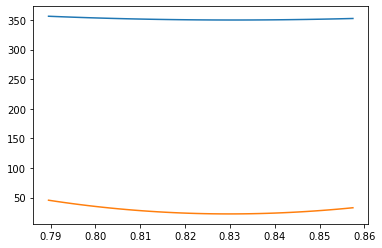

In [115]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [116]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals[si] < min_chi2 :
        min_chi2 = scan_chi2_vals[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals[si] - scan_chi2_vals[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals[si], dx, dchi2)
         )

  point for min chi2 :   24  val = 349.995
   0 :  x =   0.7895  chi2 =     356.35   dx = -0.0418  dchi2 =  6.3517
   1 :  x =   0.7913  chi2 =     355.82   dx = -0.0400  dchi2 =  5.8208
   2 :  x =   0.7930  chi2 =     355.31   dx = -0.0383  dchi2 =  5.3136
   3 :  x =   0.7948  chi2 =     354.82   dx = -0.0365  dchi2 =  4.8301
   4 :  x =   0.7965  chi2 =     354.36   dx = -0.0348  dchi2 =  4.3700
   5 :  x =   0.7982  chi2 =     353.93   dx = -0.0331  dchi2 =  3.9334
   6 :  x =   0.8000  chi2 =     353.52   dx = -0.0313  dchi2 =  3.5201
   7 :  x =   0.8017  chi2 =     353.13   dx = -0.0296  dchi2 =  3.1302
   8 :  x =   0.8035  chi2 =     352.76   dx = -0.0278  dchi2 =  2.7635
   9 :  x =   0.8052  chi2 =     352.41   dx = -0.0261  dchi2 =  2.4199
  10 :  x =   0.8070  chi2 =     352.09   dx = -0.0244  dchi2 =  2.0995
  11 :  x =   0.8087  chi2 =     351.80   dx = -0.0226  dchi2 =  1.8020
  12 :  x =   0.8104  chi2 =     351.52   dx = -0.0209  dchi2 =  1.5275
  13 :  x =   0.8122 

In [117]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals_diagonal[si] < min_chi2 :
        min_chi2 = scan_chi2_vals_diagonal[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals_diagonal[si] - scan_chi2_vals_diagonal[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals_diagonal[si], dx, dchi2)
         )


  point for min chi2 :   23  val =  22.280
   0 :  x =   0.7895  chi2 =      45.44   dx = -0.0400  dchi2 = 23.1551
   1 :  x =   0.7913  chi2 =      43.46   dx = -0.0383  dchi2 = 21.1750
   2 :  x =   0.7930  chi2 =      41.57   dx = -0.0365  dchi2 = 19.2855
   3 :  x =   0.7948  chi2 =      39.77   dx = -0.0348  dchi2 = 17.4862
   4 :  x =   0.7965  chi2 =      38.06   dx = -0.0331  dchi2 = 15.7769
   5 :  x =   0.7982  chi2 =      36.44   dx = -0.0313  dchi2 = 14.1571
   6 :  x =   0.8000  chi2 =      34.91   dx = -0.0296  dchi2 = 12.6267
   7 :  x =   0.8017  chi2 =      33.47   dx = -0.0278  dchi2 = 11.1854
   8 :  x =   0.8035  chi2 =      32.11   dx = -0.0261  dchi2 =  9.8327
   9 :  x =   0.8052  chi2 =      30.85   dx = -0.0244  dchi2 =  8.5686
  10 :  x =   0.8070  chi2 =      29.67   dx = -0.0226  dchi2 =  7.3926
  11 :  x =   0.8087  chi2 =      28.58   dx = -0.0209  dchi2 =  6.3044
  12 :  x =   0.8104  chi2 =      27.58   dx = -0.0191  dchi2 =  5.3039
  13 :  x =   0.8122 

In [118]:
boot_hist_content.shape

(500, 20)

In [119]:
len(boot_hist_content)

500

In [120]:

chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



for si in range( len(boot_hist_content) ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    #fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.1832 +/-   0.0114  (  0.1956 +/-   0.0061)    sig2   0.8159 +/-   0.0166  (  0.8192 +/-   0.0083)
   1 : mu   0.1991 +/-   0.0114  (  0.2165 +/-   0.0060)    sig2   0.8110 +/-   0.0174  (  0.8036 +/-   0.0086)
   2 : mu   0.1925 +/-   0.0115  (  0.2056 +/-   0.0061)    sig2   0.8398 +/-   0.0169  (  0.8408 +/-   0.0085)
   3 : mu   0.1847 +/-   0.0113  (  0.1959 +/-   0.0060)    sig2   0.8154 +/-   0.0166  (  0.8143 +/-   0.0083)
   4 : mu   0.1784 +/-   0.0112  (  0.1914 +/-   0.0060)    sig2   0.8299 +/-   0.0166  (  0.8300 +/-   0.0083)
   5 : mu   0.1983 +/-   0.0115  (  0.2120 +/-   0.0061)    sig2   0.8242 +/-   0.0172  (  0.8216 +/-   0.0085)
   6 : mu   0.1728 +/-   0.0115  (  0.1851 +/-   0.0061)    sig2   0.8378 +/-   0.0177  (  0.8251 +/-   0.0088)
   7 : mu   0.1947 +/-   0.0115  (  0.2075 +/-   0.0061)    sig2   0.8242 +/-   0.0168  (  0.8197 +/-   0.0085)
   8 : mu   0.1680 +/-   0.0114  (  0.1847 +/-   0.0061)    sig2   0.8060 +/-   0.0170  (  0.8018 +/-   

  74 : mu   0.1912 +/-   0.0114  (  0.2033 +/-   0.0061)    sig2   0.8712 +/-   0.0168  (  0.8851 +/-   0.0086)
  75 : mu   0.1827 +/-   0.0113  (  0.1916 +/-   0.0060)    sig2   0.8208 +/-   0.0165  (  0.8189 +/-   0.0083)
  76 : mu   0.1880 +/-   0.0115  (  0.2053 +/-   0.0061)    sig2   0.8205 +/-   0.0165  (  0.8206 +/-   0.0083)
  77 : mu   0.1708 +/-   0.0114  (  0.1860 +/-   0.0060)    sig2   0.8274 +/-   0.0169  (  0.8280 +/-   0.0083)
  78 : mu   0.1877 +/-   0.0115  (  0.2006 +/-   0.0061)    sig2   0.8263 +/-   0.0166  (  0.8253 +/-   0.0083)
  79 : mu   0.2014 +/-   0.0112  (  0.2145 +/-   0.0060)    sig2   0.8198 +/-   0.0162  (  0.8210 +/-   0.0082)
  80 : mu   0.1909 +/-   0.0113  (  0.2012 +/-   0.0060)    sig2   0.8262 +/-   0.0164  (  0.8255 +/-   0.0083)
  81 : mu   0.1733 +/-   0.0112  (  0.1844 +/-   0.0060)    sig2   0.8068 +/-   0.0167  (  0.8041 +/-   0.0084)
  82 : mu   0.1815 +/-   0.0115  (  0.1977 +/-   0.0061)    sig2   0.8512 +/-   0.0167  (  0.8631 +/-   

 247 : mu   0.1627 +/-   0.0115  (  0.1706 +/-   0.0061)    sig2   0.8297 +/-   0.0167  (  0.8306 +/-   0.0085)
 248 : mu   0.1923 +/-   0.0113  (  0.2052 +/-   0.0060)    sig2   0.8309 +/-   0.0169  (  0.8293 +/-   0.0085)
 249 : mu   0.1826 +/-   0.0112  (  0.1964 +/-   0.0060)    sig2   0.8090 +/-   0.0161  (  0.8108 +/-   0.0081)
 250 : mu   0.1821 +/-   0.0115  (  0.1941 +/-   0.0061)    sig2   0.8316 +/-   0.0167  (  0.8388 +/-   0.0084)
 251 : mu   0.1920 +/-   0.0114  (  0.2015 +/-   0.0061)    sig2   0.8153 +/-   0.0165  (  0.8108 +/-   0.0083)
 252 : mu   0.1950 +/-   0.0113  (  0.2113 +/-   0.0060)    sig2   0.7922 +/-   0.0165  (  0.7969 +/-   0.0082)
 253 : mu   0.1974 +/-   0.0113  (  0.2057 +/-   0.0060)    sig2   0.8168 +/-   0.0167  (  0.8196 +/-   0.0084)
 254 : mu   0.1799 +/-   0.0113  (  0.1945 +/-   0.0060)    sig2   0.8090 +/-   0.0166  (  0.8173 +/-   0.0082)
 255 : mu   0.1832 +/-   0.0114  (  0.1950 +/-   0.0061)    sig2   0.8443 +/-   0.0170  (  0.8490 +/-   

 396 : mu   0.1827 +/-   0.0112  (  0.1941 +/-   0.0060)    sig2   0.8325 +/-   0.0160  (  0.8390 +/-   0.0082)
 397 : mu   0.1819 +/-   0.0112  (  0.1964 +/-   0.0060)    sig2   0.7977 +/-   0.0169  (  0.8009 +/-   0.0085)
 398 : mu   0.1719 +/-   0.0114  (  0.1870 +/-   0.0060)    sig2   0.8551 +/-   0.0169  (  0.8635 +/-   0.0085)
 399 : mu   0.1962 +/-   0.0114  (  0.2135 +/-   0.0061)    sig2   0.8270 +/-   0.0171  (  0.8184 +/-   0.0085)
 400 : mu   0.2010 +/-   0.0116  (  0.2144 +/-   0.0061)    sig2   0.8343 +/-   0.0171  (  0.8260 +/-   0.0085)
 401 : mu   0.2002 +/-   0.0114  (  0.2120 +/-   0.0061)    sig2   0.8675 +/-   0.0172  (  0.8550 +/-   0.0086)
 402 : mu   0.1976 +/-   0.0116  (  0.2107 +/-   0.0062)    sig2   0.8222 +/-   0.0170  (  0.8304 +/-   0.0087)
 403 : mu   0.1763 +/-   0.0116  (  0.1908 +/-   0.0062)    sig2   0.8475 +/-   0.0168  (  0.8526 +/-   0.0085)
 404 : mu   0.1763 +/-   0.0116  (  0.1893 +/-   0.0062)    sig2   0.8172 +/-   0.0171  (  0.8177 +/-   

<function matplotlib.pyplot.show(close=None, block=None)>

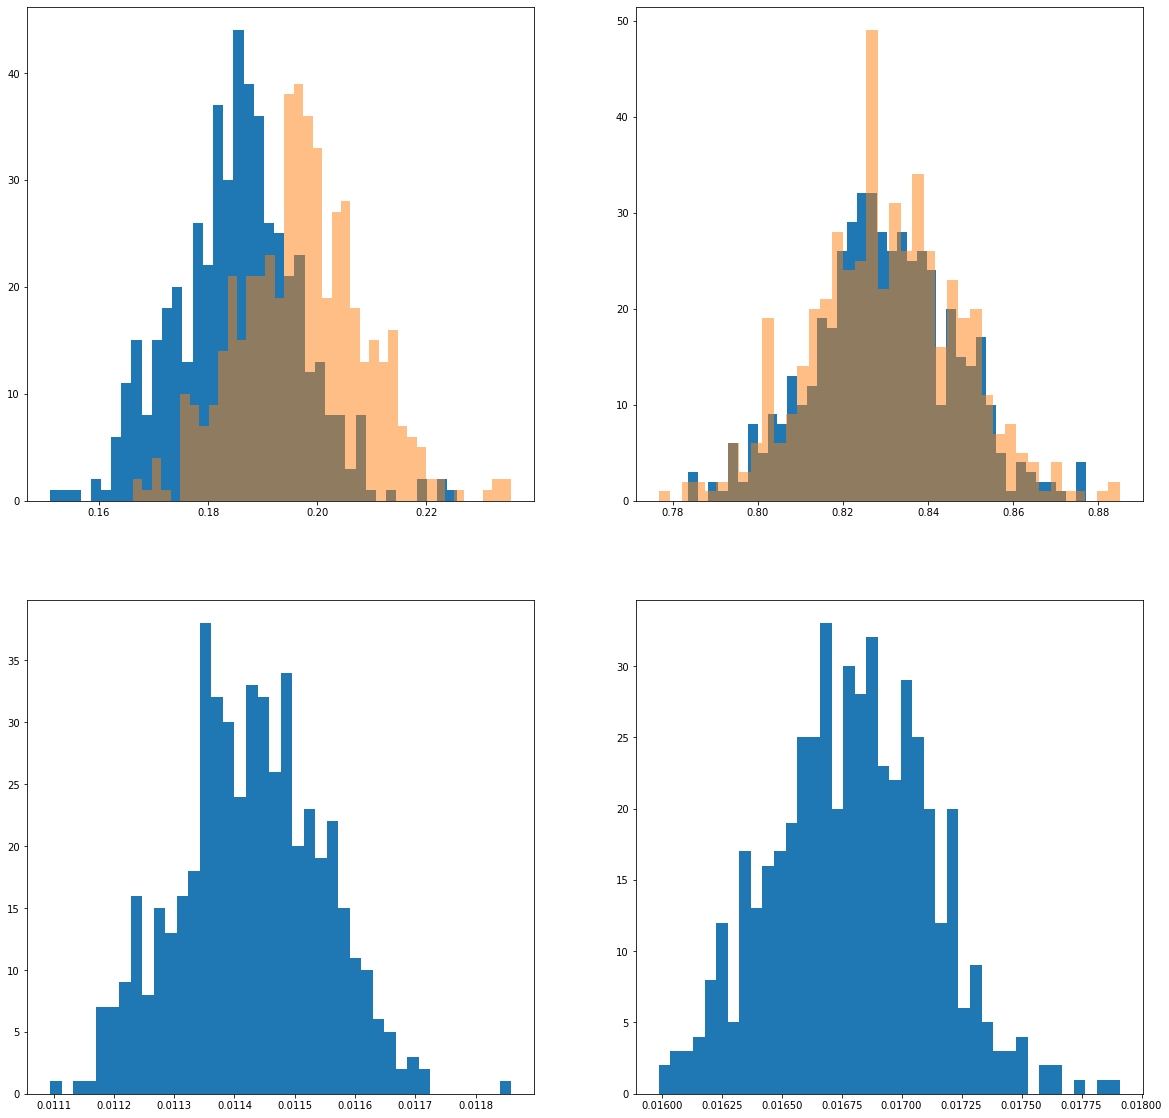

In [121]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [122]:



mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')






 mean:  0.1852, rms  0.0113, mean fit err  0.0114  |  diag. chi2 fit    0.1973, rms  0.0114, mean fit err  0.0061
 sig2:  0.8297, rms  0.0165, mean fit err  0.0168  |  diag. chi2 fit    0.8301, rms  0.0176, mean fit err  0.0085





<function matplotlib.pyplot.show(close=None, block=None)>

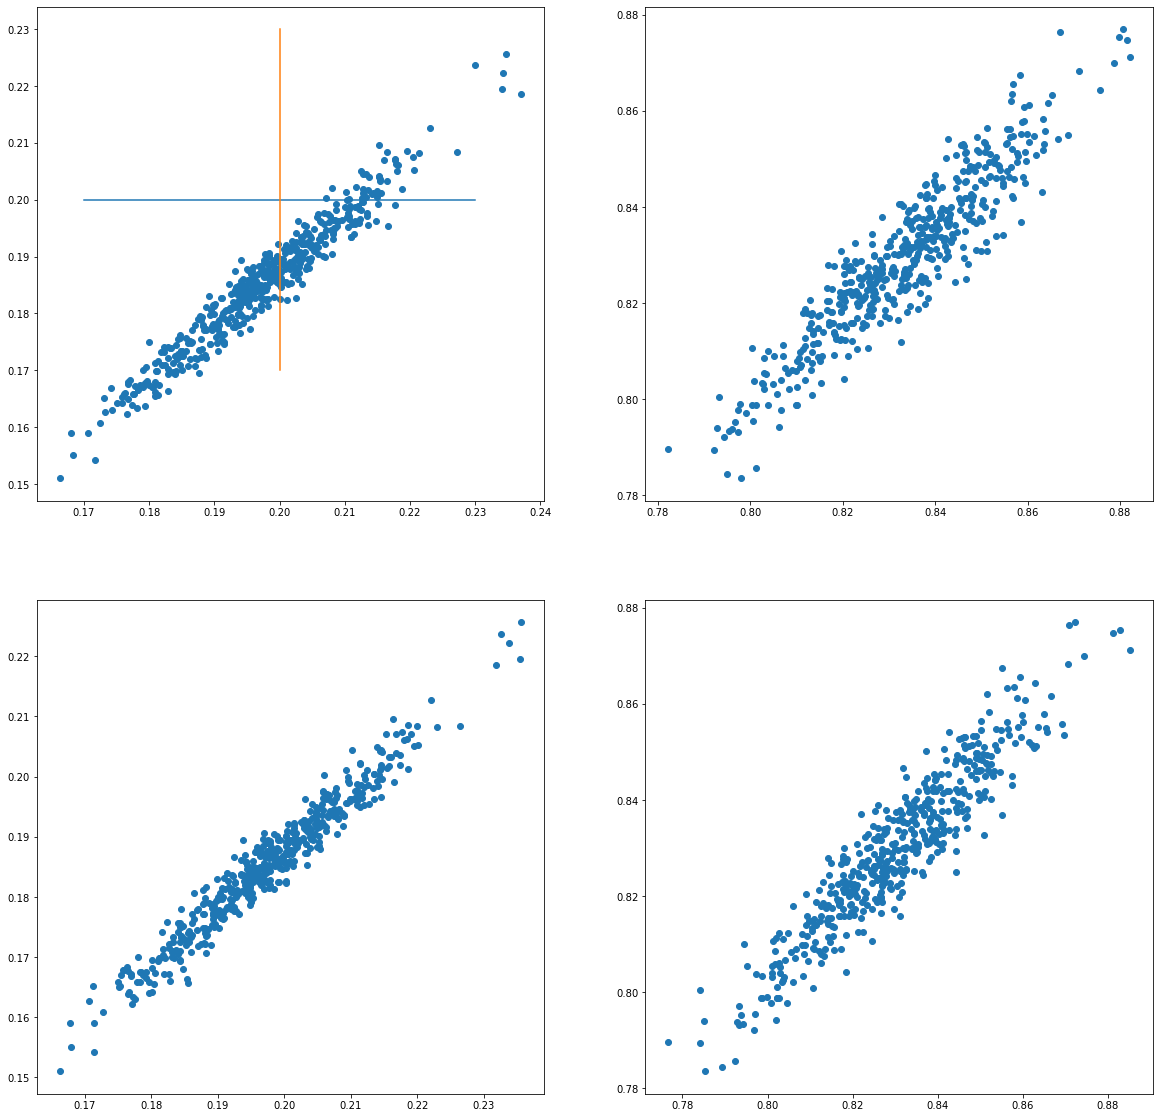

In [123]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].scatter( simple_calc_mean, chi2_fit_mu_val )
ax[0][1].scatter( simple_calc_cov, chi2_fit_sig2_val )
ax[0][0].plot( [0.17,0.23], [0.2,0.2])
ax[0][0].plot( [0.2,0.2], [0.17,0.23])


ax[1][0].scatter( chi2_fit_diag_mu_val, chi2_fit_mu_val )
ax[1][1].scatter( chi2_fit_diag_sig2_val, chi2_fit_sig2_val )

plt.show